In [70]:
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.utils import Sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Dropout, BatchNormalization, MaxPooling2D, Activation

In [85]:
def normalize(arr):
    min_val = np.min(arr)
    max_val = np.max(arr)
    return 2 * (arr - min_val) / (max_val - min_val) - 1

In [71]:
# Load all images

In [72]:
# Load all metadata

In [73]:
# Load images
filename = r'D:\comma-dataset\camera\2016-01-30--11-24-51.h5'
camera = h5py.File(filename,'r')

for field in camera.keys():
    print(field)

imgs = camera.get('X')
imgs = np.array(imgs)

print('Loaded images = ', imgs.shape[0])
print('Image shape = ', np.shape(imgs)[1:])

X
Loaded images =  52722
Image shape =  (3, 160, 320)


In [74]:
filename = r'D:\comma-dataset\log\2016-01-30--11-24-51.h5'
logs = h5py.File(filename,'r')

# Load necessary information sampled at 100 Hz
steering_angle = np.array(logs.get('steering_angle')).reshape(-1,1)
speed = np.array(logs.get('speed')).reshape(-1,1)
acceleration = np.array(logs.get('car_accel')).reshape(-1,1)
brake = np.array(logs.get('brake')).reshape(-1,1)
stopped = np.array(logs.get('standstill')).reshape(-1,1)
cam_index = np.array(logs.get('cam1_ptr')).reshape(-1,1)

# Concatenate all arrays to df
data = pd.DataFrame(
    np.hstack((steering_angle, speed, acceleration, brake, stopped, cam_index)),
    columns=['steering_angle', 'speed', 'acceleration', 'brake', 'stopped', 'cam_index']
)

data.head()

,steering_angle,speed,acceleration,brake,stopped,cam_index
0,80.0,0.0,0.0,63872.0,0.0,0.0
1,80.0,0.0,0.0,63872.0,0.0,0.0
2,80.0,0.0,0.0,63872.0,0.0,0.0
3,80.0,0.0,0.0,63872.0,0.0,0.0
4,80.0,0.0,0.0,63872.0,0.0,0.0


In [75]:
data.describe()

,steering_angle,speed,acceleration,brake,stopped,cam_index
count,263583.000000,263583.000000,263583.000000,263583.000000,263583.000000,263583.000000
mean,22.495368,18.469584,-0.006569,236.890389,0.855256,26356.901450
std,605.378073,12.709778,0.712962,1990.971916,0.351843,15222.186645
min,-5121.000000,-1.832309,-4.596708,-64.000000,0.000000,0.000000
25%,-13.000000,4.734308,-0.268545,0.000000,1.000000,13174.000000
50%,2.000000,25.933573,0.000000,0.000000,1.000000,26356.000000
75%,18.584913,30.029360,0.226096,128.000000,1.000000,39540.000000
max,5011.000000,35.879706,5.121176,63872.000000,1.000000,52721.000000


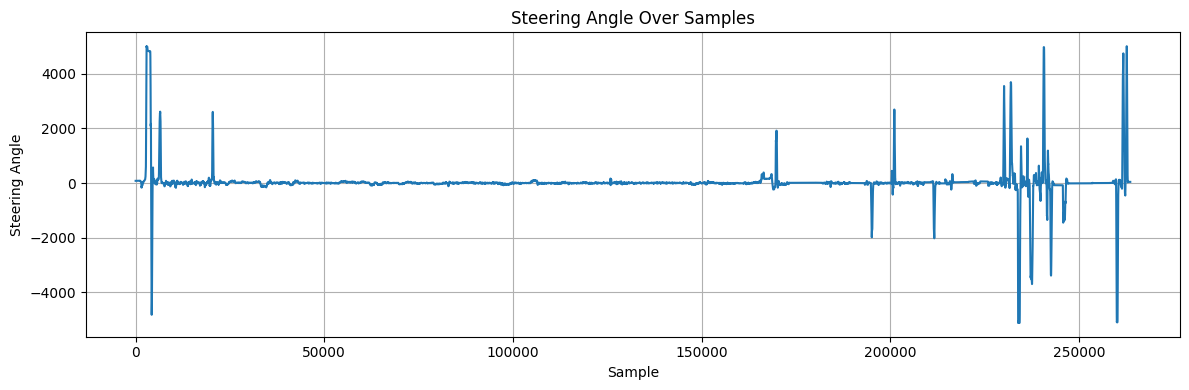

In [76]:
# Plot steering angle over time
plt.figure(figsize=(12, 4))
plt.plot(data['steering_angle'], label='Steering Angle')
plt.xlabel('Sample')
plt.ylabel('Steering Angle')
plt.title('Steering Angle Over Samples')
plt.grid(True)
plt.tight_layout()
plt.show()

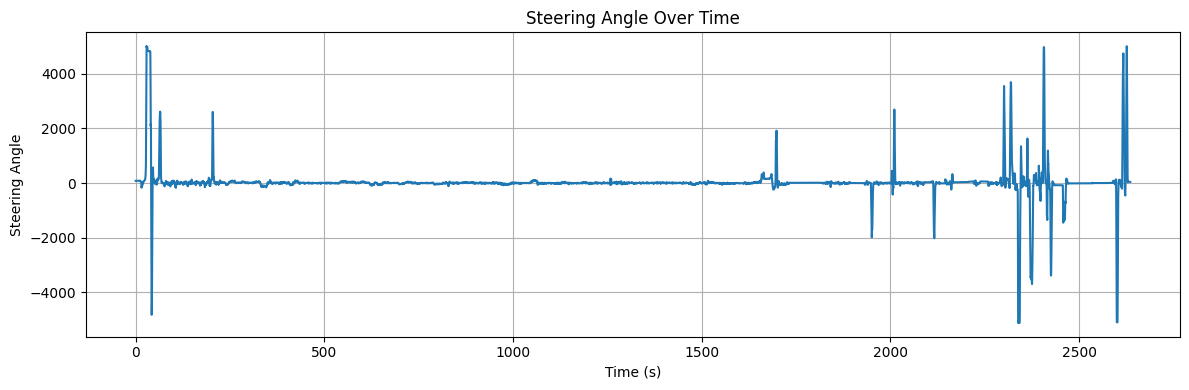

In [77]:
# Time axis assuming 100 Hz sampling
time = np.arange(len(data)) / 100.0 

# Plot steering angle over time
plt.figure(figsize=(12, 4))
plt.plot(time, data['steering_angle'], label='Steering Angle')
plt.xlabel('Time (s)')
plt.ylabel('Steering Angle')
plt.title('Steering Angle Over Time')
plt.grid(True)
plt.tight_layout()
plt.show()

In [78]:
# Downsample to prevent redundant entries
data_downsampled = data.iloc[::10, :]
data_downsampled.describe()

,steering_angle,speed,acceleration,brake,stopped,cam_index
count,26359.000000,26359.000000,26359.000000,26359.000000,26359.000000,26359.000000
mean,22.496507,18.469126,-0.006211,237.197412,0.855040,26355.291362
std,605.387058,12.710239,0.712639,1993.878549,0.352067,15222.833753
min,-5121.000000,-1.798662,-4.571521,-64.000000,0.000000,0.000000
25%,-13.000000,4.731583,-0.265959,0.000000,1.000000,13173.000000
50%,2.000000,25.932086,0.000000,0.000000,1.000000,26355.000000
75%,18.783206,30.028582,0.221794,130.192964,1.000000,39538.000000
max,5010.911211,35.829370,4.969861,63872.000000,1.000000,52720.000000


In [79]:
data_downsampled.head()

,steering_angle,speed,acceleration,brake,stopped,cam_index
0,80.0,0.0,0.0,63872.0,0.0,0.0
10,80.0,0.0,0.0,63872.0,0.0,0.0
20,80.0,0.0,0.0,63872.0,0.0,0.0
30,80.0,0.0,0.0,63872.0,0.0,0.0
40,80.0,0.0,0.0,63872.0,0.0,0.0


In [80]:
print(data_downsampled['cam_index'])

0             0.0
10            0.0
20            0.0
30            0.0
40            0.0
           ...   
263540    52714.0
263550    52716.0
263560    52718.0
263570    52720.0
263580        0.0
Name: cam_index, Length: 26359, dtype: float64


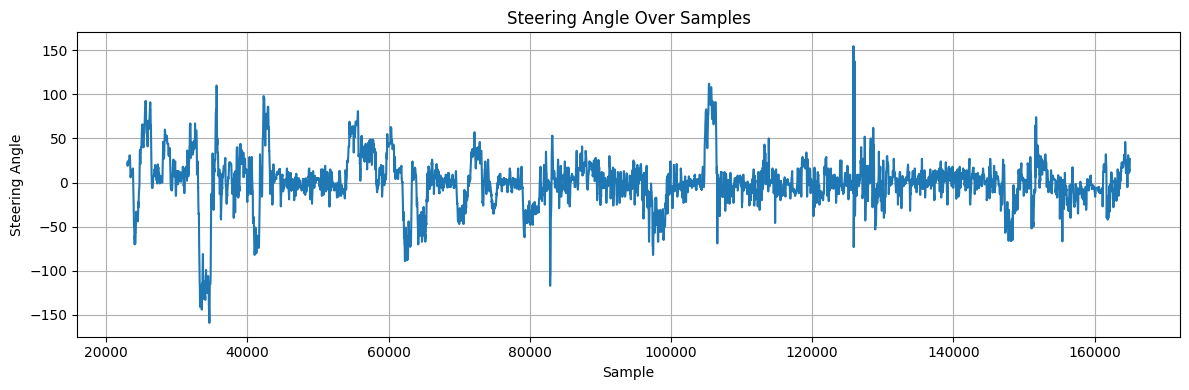

In [81]:
# Cut out start and end behavior for more consisent predictions
data_downsampled = data_downsampled.iloc[2300:16500]

# Plot steering angle over time
plt.figure(figsize=(12, 4))
plt.plot(data_downsampled['steering_angle'], label='Steering Angle')
plt.xlabel('Sample')
plt.ylabel('Steering Angle')
plt.title('Steering Angle Over Samples')
plt.grid(True)
plt.tight_layout()
plt.show()

Training sequences shape =  (12070, 160, 320, 3)
Training target shape =  (12070,)


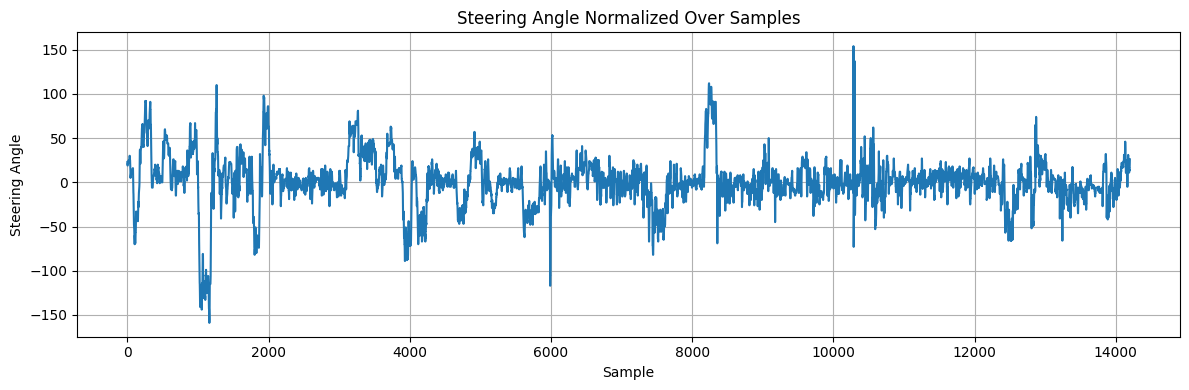

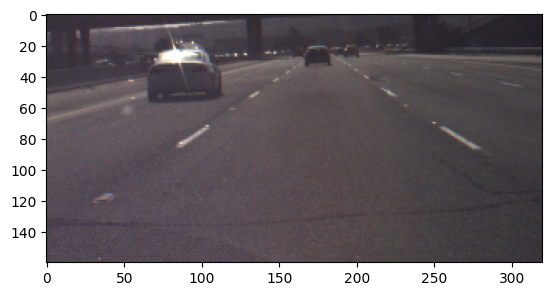

In [101]:
# Get the training index as cam_index
train_index = data_downsampled['cam_index'].values.astype(int)

# Set X variable as images
X_train = imgs[train_index]
X_train = X_train.transpose(0, 2, 3, 1)
print('Training sequences shape = ', np.shape(train_X))

# Set Y variable as the steering angle
data_downsampled['steering_angle'] = data_downsampled['steering_angle'] * (np.pi / 180)
Y_train = data_downsampled['steering_angle'].values.astype(int)
#Y_train = normalize(data_downsampled['steering_angle'])
#Y_train = Y_train.values

print('Training target shape = ', np.shape(train_Y))

# Plot steering angle over time
plt.figure(figsize=(12, 4))
plt.plot(Y_train, label='Steering Angle')
plt.xlabel('Sample')
plt.ylabel('Steering Angle')
plt.title('Steering Angle Normalized Over Samples')
plt.grid(True)
plt.tight_layout()
plt.show()

plt.imshow(X_train[5000])
plt.show()

In [102]:
# Begin the data prep for the CNN
train_X, test_X, train_Y, test_Y = train_test_split(X_train, Y_train, test_size=0.15, random_state=53)

In [103]:
def nvidia_model(input_shape=(160, 320, 3)):
    model = Sequential()
    # 5x5 Convolutional layers with stride 2x2
    model.add(Conv2D(24, (5, 5), strides=(2, 2), activation='elu', input_shape=input_shape))
    model.add(Conv2D(36, (5, 5), strides=(2, 2), activation='elu'))
    model.add(Conv2D(48, (5, 5), strides=(2, 2), activation='elu'))
    # 3x3 Convolutional layers with stride 1x1
    model.add(Conv2D(64, (3, 3), activation='elu'))
    model.add(Conv2D(64, (3, 3), activation='elu'))
    # Flatten
    model.add(Flatten())
    # Fully connected layers
    model.add(Dense(100, activation='elu'))
    model.add(Dropout(0.25))
    model.add(Dense(50, activation='elu'))
    model.add(Dropout(0.25))
    model.add(Dense(10, activation='elu'))
    model.add(Dropout(0.25))
    # Output layer
    model.add(Dense(1, activation='linear'))
    return model

In [104]:
model = nvidia_model()

model.compile(optimizer='rmsprop',
              loss='mse',
             )

In [105]:
history = model.fit(train_X, train_Y, 
                    batch_size=32, 
                    epochs=5, 
                    shuffle=True)

Epoch 1/3
95/95 [==============================] - 22s 229ms/step - loss: 3395.3850 - accuracy: 0.0280
Epoch 2/3
95/95 [==============================] - 25s 259ms/step - loss: 869.2839 - accuracy: 0.0276
Epoch 3/3
95/95 [==============================] - 22s 228ms/step - loss: 904.5985 - accuracy: 0.0284


67/67 [==============================] - 1s 18ms/step
[[0.7872921]
 [0.7872921]
 [0.7872921]
 ...
 [0.7872921]
 [0.7872921]
 [0.7872921]]


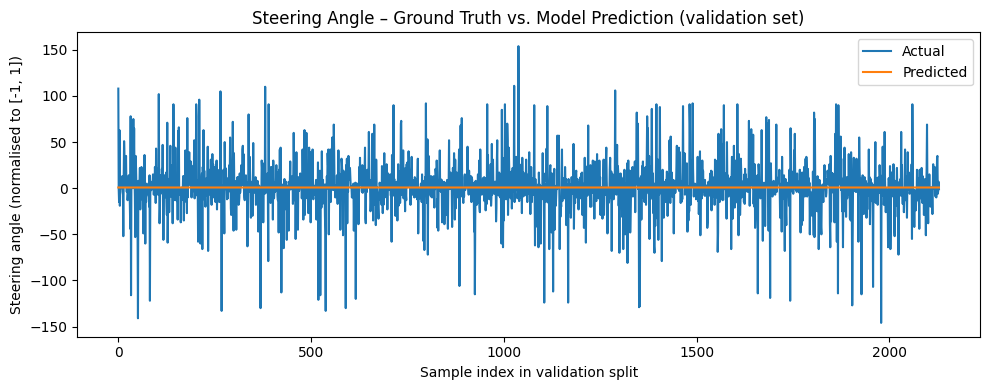

In [106]:
y_pred = model.predict(test_X)
print(y_pred)
y_true = test_Y

plt.figure(figsize=(10, 4))
plt.plot(y_true, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title('Steering Angle – Ground Truth vs. Model Prediction (validation set)')
plt.xlabel('Sample index in validation split')
plt.ylabel('Steering angle (normalised to [-1, 1])')
plt.legend()
plt.tight_layout()
plt.show()